In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

10373 2593


In [ ]:
class LegoImagesDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
# Dataset
dataset = load_dataset("Armaggheddon/lego_minifigure_captions", split="train")
full_dataset = LegoImagesDataset(dataset, transform=transform)

val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(len(train_ds), len(val_ds))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAEPlus(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.Flatten()
        )

        self.flatten_dim = 512 * 4 * 4

        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 4, 4)),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded_input = self.decoder_input(z)
        x_recon = self.decoder(decoded_input)
        return x_recon, mu, logvar

In [ ]:
# Loss
def vae_loss(recon_x, x, mu, logvar, beta=0.1):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

In [4]:
# Training
def train_vae(model, train_loader, val_loader, device, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x in train_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss = vae_loss(recon_x, x, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x in val_loader:
                x = x.to(device)
                recon_x, mu, logvar = model(x)
                val_loss += vae_loss(recon_x, x, mu, logvar).item()

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.2f} - Val Loss: {val_loss:.2f}")

        if (epoch + 1) % 10 == 0:
            show_result_vae(model, val_loader, device)

In [5]:
# Show results
def show_result_vae(model, loader, device, n=8):
    model.eval()
    with torch.no_grad():
        images = next(iter(loader))
        images = images[:n].to(device)
        recon_images, _, _ = model(images)
        recon_images = recon_images.cpu()

    comparison = torch.cat([images.cpu(), recon_images])
    grid = torchvision.utils.make_grid(comparison, nrow=n, normalize=True)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Original vs Reconstructed")
    plt.show()

In [6]:
# Generate image
def generate_images(model, device, n=8):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, model.latent_dim).to(device)
        z = model.decoder_input(z)
        gen_images = model.decoder(z).cpu()

    grid = torchvision.utils.make_grid(gen_images, nrow=n, normalize=True)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("LEGO")
    plt.show()

c:\Users\jastr\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1 - Train Loss: 229641102.87 - Val Loss: 48050163.12
Epoch 2 - Train Loss: 175973222.77 - Val Loss: 44812954.81
Epoch 3 - Train Loss: 171225280.12 - Val Loss: 43486705.81
Epoch 4 - Train Loss: 168018678.49 - Val Loss: 42945404.06
Epoch 5 - Train Loss: 164605177.61 - Val Loss: 42648197.69
Epoch 6 - Train Loss: 162863287.09 - Val Loss: 42107650.31
Epoch 7 - Train Loss: 161139334.12 - Val Loss: 41448707.47
Epoch 8 - Train Loss: 159962113.65 - Val Loss: 42342948.94
Epoch 9 - Train Loss: 159322665.08 - Val Loss: 41114333.22
Epoch 10 - Train Loss: 158369362.39 - Val Loss: 40747938.19


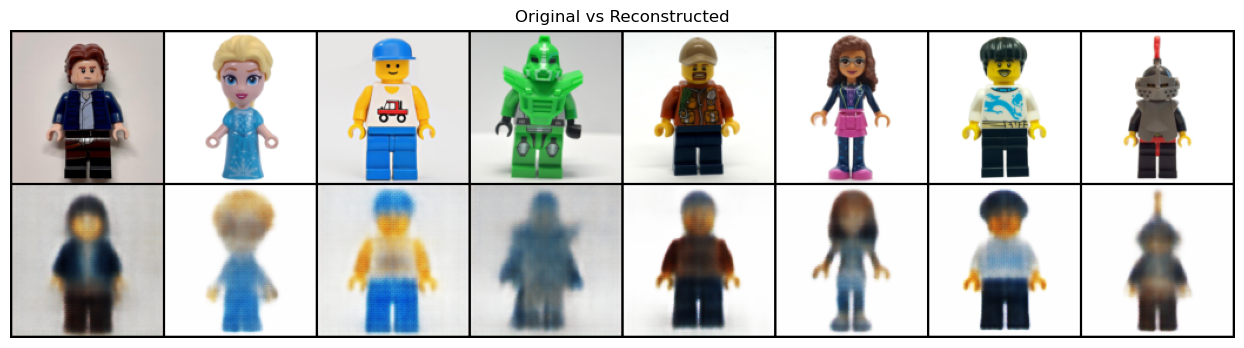

Epoch 11 - Train Loss: 157782508.31 - Val Loss: 41093237.31
Epoch 12 - Train Loss: 157499137.71 - Val Loss: 40414724.09
Epoch 13 - Train Loss: 156843858.45 - Val Loss: 40598698.47
Epoch 14 - Train Loss: 156186480.05 - Val Loss: 40370009.19
Epoch 15 - Train Loss: 155878376.44 - Val Loss: 40380766.06
Epoch 16 - Train Loss: 156431104.08 - Val Loss: 40275800.69
Epoch 17 - Train Loss: 155283481.66 - Val Loss: 40017486.78
Epoch 18 - Train Loss: 154765616.28 - Val Loss: 40055548.31
Epoch 19 - Train Loss: 158021100.55 - Val Loss: 40703128.12
Epoch 20 - Train Loss: 155013477.66 - Val Loss: 40030065.03


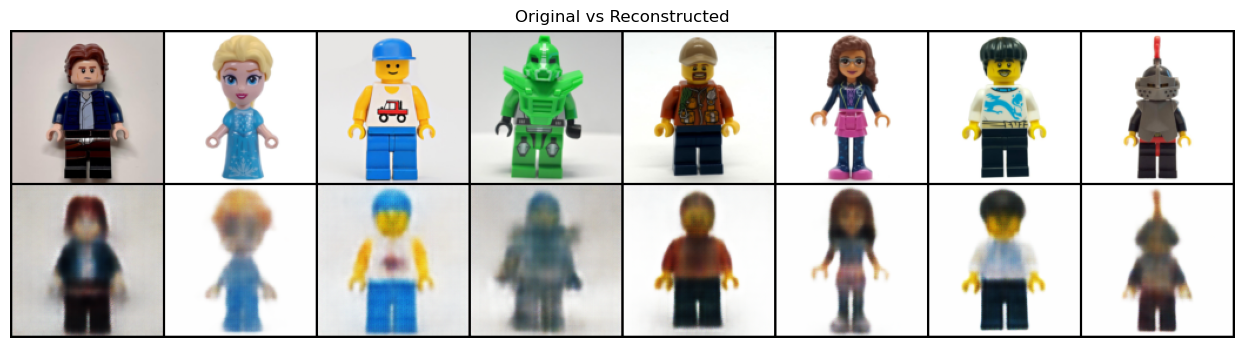

Epoch 21 - Train Loss: 154446303.34 - Val Loss: 39845250.97
Epoch 22 - Train Loss: 154078706.89 - Val Loss: 40274986.06
Epoch 23 - Train Loss: 155419039.66 - Val Loss: 40194636.88
Epoch 24 - Train Loss: 153893517.80 - Val Loss: 39802681.50
Epoch 25 - Train Loss: 153423518.25 - Val Loss: 39780350.22
Epoch 26 - Train Loss: 153152736.83 - Val Loss: 40202841.66
Epoch 27 - Train Loss: 152935687.78 - Val Loss: 39479005.97
Epoch 28 - Train Loss: 152706091.95 - Val Loss: 39717216.56
Epoch 29 - Train Loss: 152571083.02 - Val Loss: 39692352.91
Epoch 30 - Train Loss: 152431029.89 - Val Loss: 39662090.41


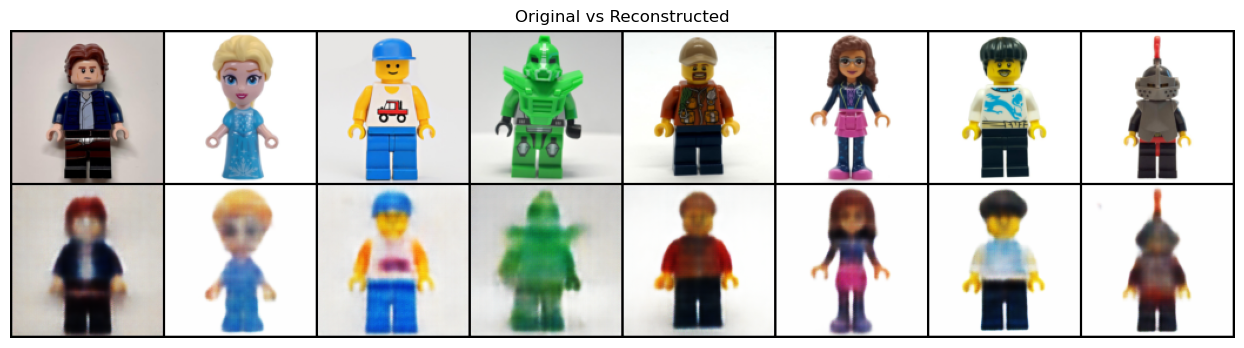

Epoch 31 - Train Loss: 154577258.52 - Val Loss: 40905265.19
Epoch 32 - Train Loss: 153295350.23 - Val Loss: 39519269.22
Epoch 33 - Train Loss: 152411809.59 - Val Loss: 39546649.78


In [ ]:
vae2 = VAEPlus(latent_dim=256)
train_vae(vae2, train_loader, val_loader, device, epochs=50)

In [ ]:
show_result_vae(vae2, val_loader, device)

In [ ]:
generate_images(vae2, device)

In [ ]:
torch.save(vae2.state_dict(), "vae2.pth")
#vae2.load_state_dict(torch.load("vae2.pth", map_location=device))
#vae2.eval